In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plot
import seaborn as sns

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [33]:
#reading of csv files
df_rating = pd.read_csv('ratings.csv')
df_tags = pd.read_csv('tags.csv')
df_movie = pd.read_csv('movies.csv')
df_links = pd.read_csv('links.csv')

In [4]:
df_rating.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [6]:
#Convert timestamp tp date 
df_rating['timestamp'] = df_rating['timestamp'].apply(datetime.fromtimestamp)
df_rating['year'] = df_rating['timestamp'].dt.year
df_rating['month'] = df_rating['timestamp'].dt.month
df_rating['date'] = df_rating['timestamp'].dt.date
df_rating = df_rating.sort_values('timestamp').reset_index(drop=True)

In [7]:
df_rating.head()

,userId,movieId,rating,timestamp,year,month,date
0,429,595,5.0,1996-03-29 18:36:55,1996,3,1996-03-29
1,429,588,5.0,1996-03-29 18:36:55,1996,3,1996-03-29
2,429,590,5.0,1996-03-29 18:36:55,1996,3,1996-03-29
3,429,592,5.0,1996-03-29 18:36:55,1996,3,1996-03-29
4,429,432,3.0,1996-03-29 18:36:55,1996,3,1996-03-29


In [8]:
df_rating.tail()

,userId,movieId,rating,timestamp,year,month,date
100831,514,187031,2.5,2018-09-23 04:55:27,2018,9,2018-09-23
100832,514,187595,3.0,2018-09-23 04:55:46,2018,9,2018-09-23
100833,514,5247,2.5,2018-09-24 03:44:00,2018,9,2018-09-24
100834,514,5246,1.5,2018-09-24 03:44:19,2018,9,2018-09-24
100835,514,162,4.0,2018-09-24 15:27:30,2018,9,2018-09-24


Exploratory Analysis

In [9]:
print('Years:', df_rating.year.unique())
print('Months', df_rating.month.unique())
print('#Unique users:', df_rating.userId.nunique())
print('#Unique movies:', df_rating.movieId.nunique())
print('Unique ratings:', df_rating.rating.unique())
print('Average rating:', round(df_rating.rating.mean(), 2))
print('Frequency of each rating value:')
print(df_rating['rating'].value_counts())

Years: [1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 2015 2016 2017 2018]
Months [ 3  4  5  6  7  8  9 10 11 12  1  2]
#Unique users: 610
#Unique movies: 9724
Unique ratings: [5.  3.  4.  2.  1.  4.5 3.5 2.5 1.5 0.5]
Average rating: 3.5
Frequency of each rating value:
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64


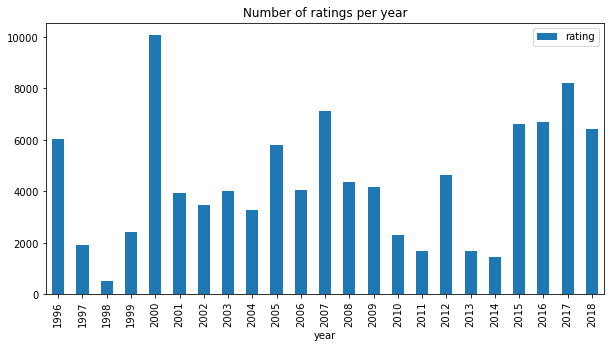

In [13]:
df_rating[['year', 'rating']].groupby(['year']).count().reset_index().plot.bar(x='year', y='rating', title='Number of ratings per year', figsize=(10, 5));

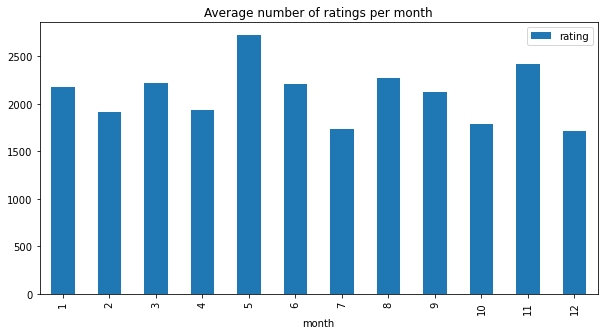

In [14]:
df_temp = df_rating[['month', 'rating']].groupby(['month']).count().reset_index()
df_temp['rating'] = df_temp['rating'] / 4
df_temp.plot.bar(x='month', y='rating', title='Average number of ratings per month', figsize=(10, 5));

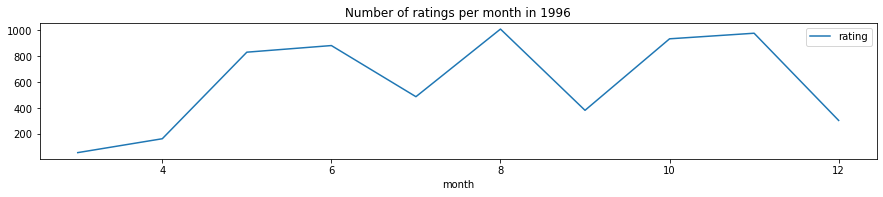

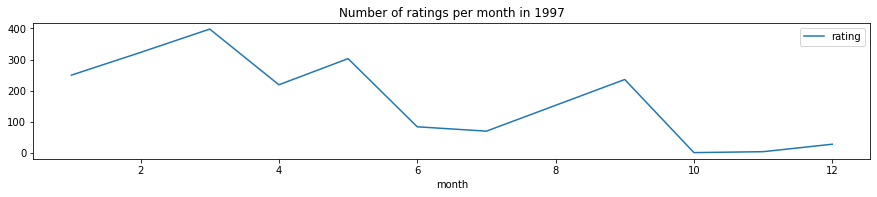

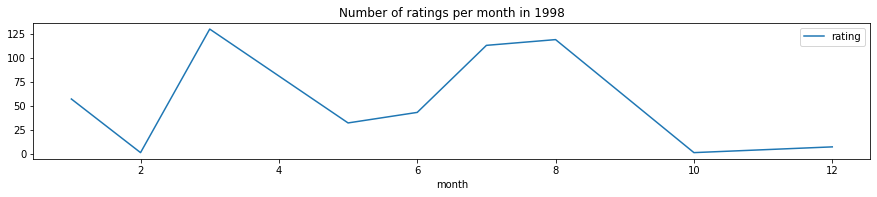

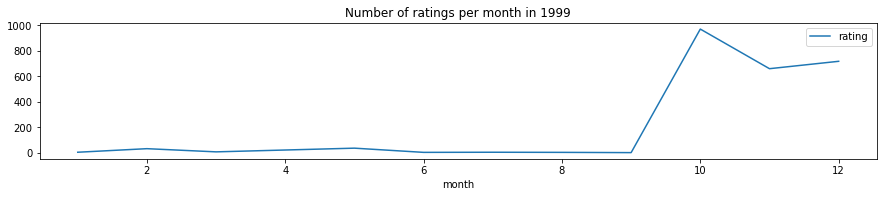

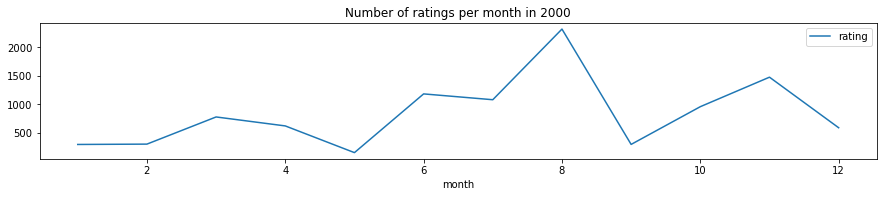

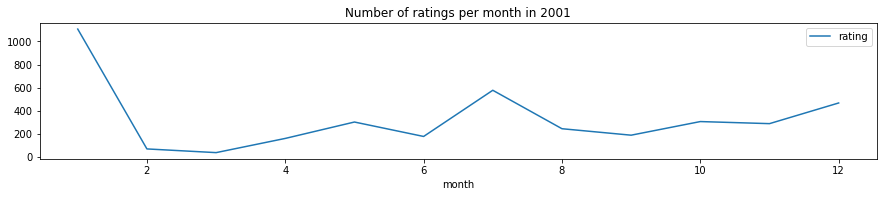

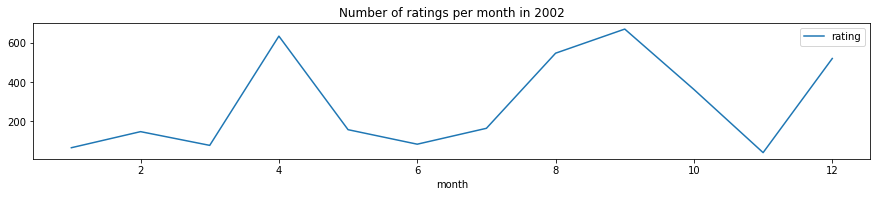

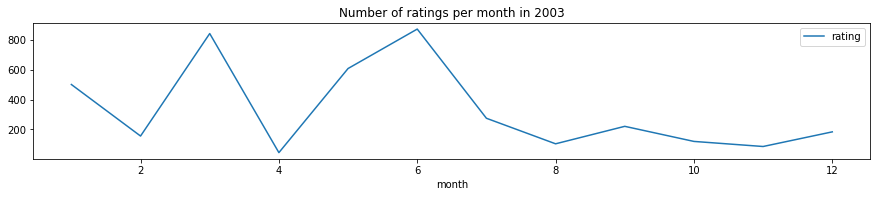

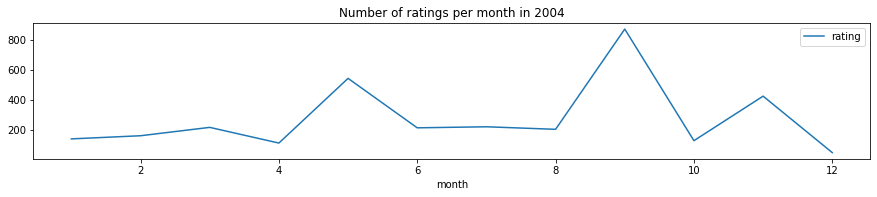

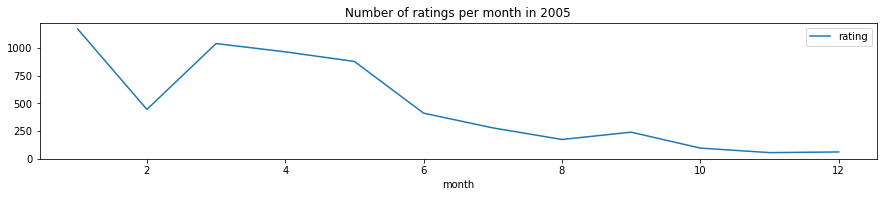

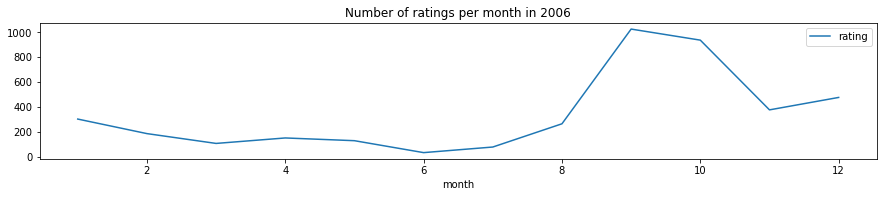

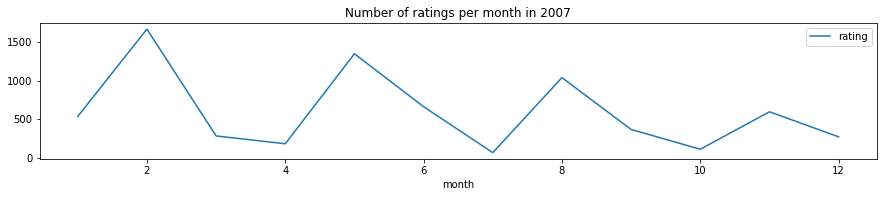

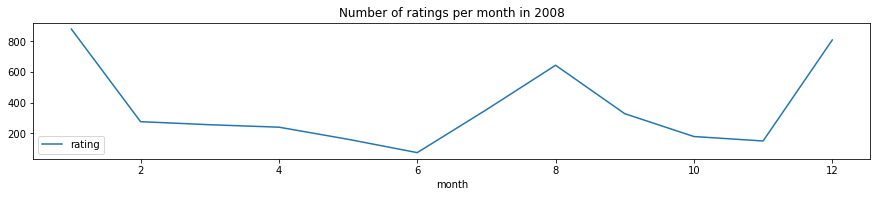

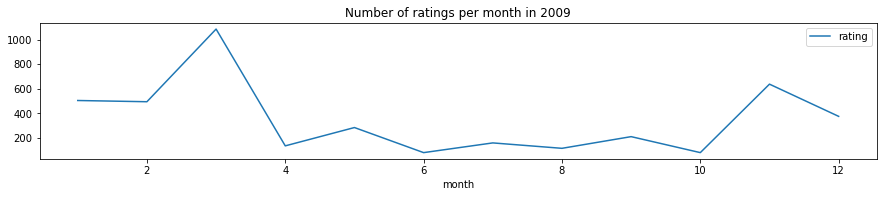

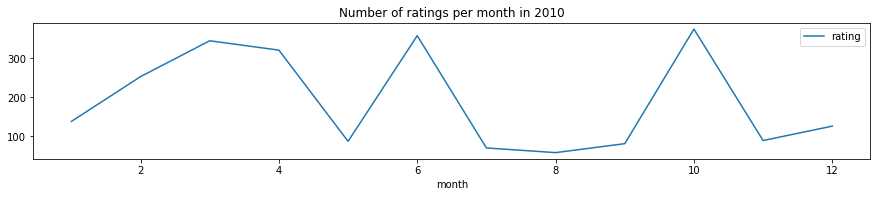

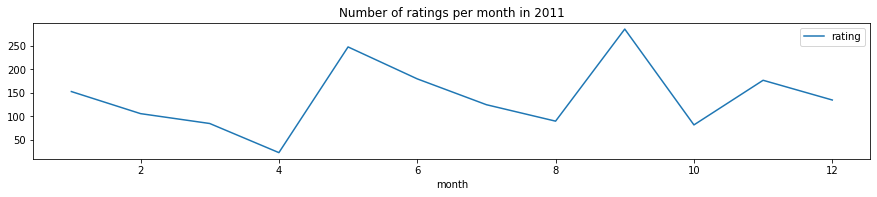

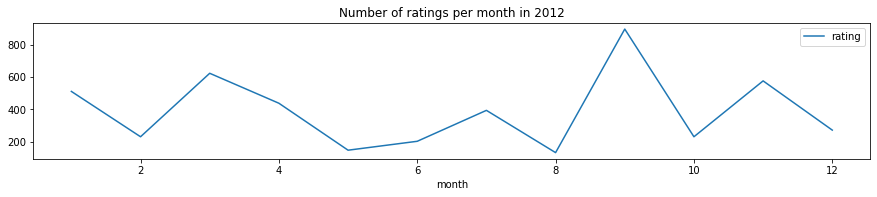

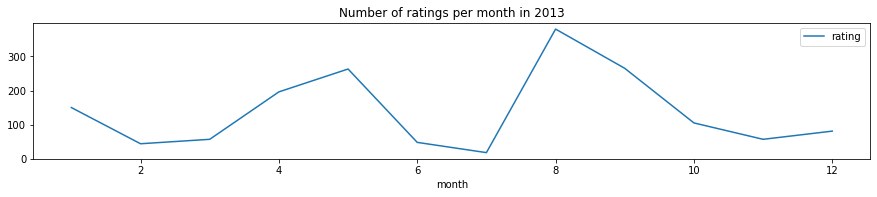

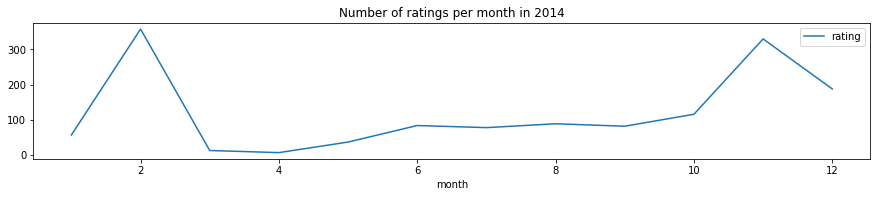

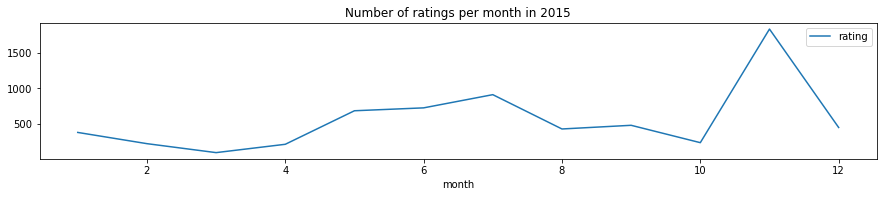

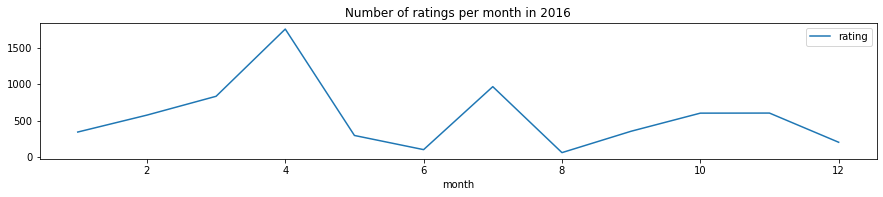

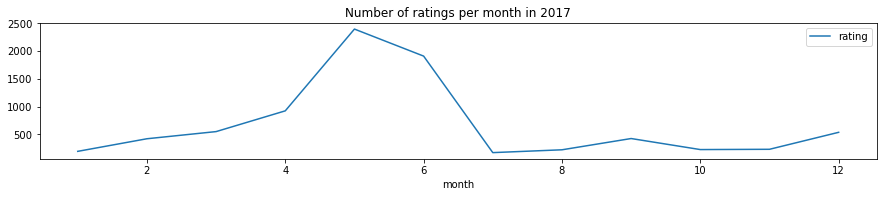

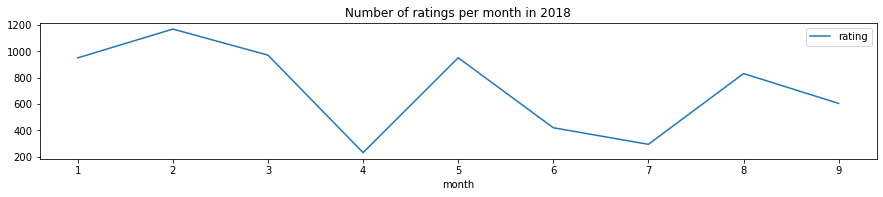

In [15]:
df_temp = df_rating[['year', 'month', 'rating']].groupby(['year', 'month']).count().reset_index()
for year in df_temp['year'].unique():
    df_temp.loc[df_temp['year'] == year].plot('month', 'rating', title='Number of ratings per month in %s' %year, figsize=(15, 2.5))

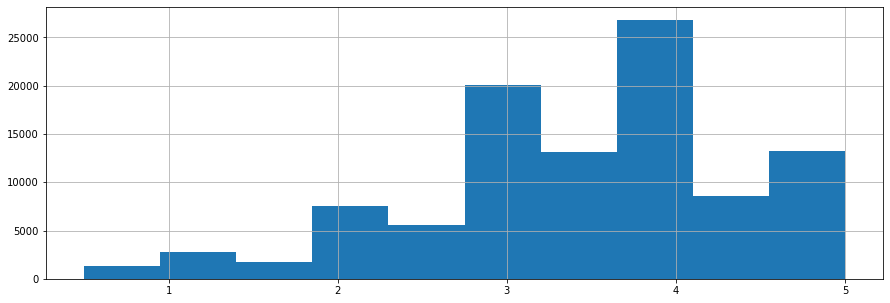

In [16]:
df_rating['rating'].hist(figsize=(15, 5));


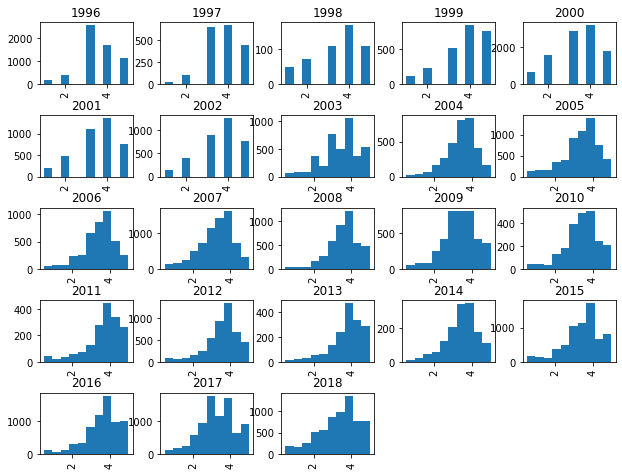

In [17]:
df_rating['rating'].hist(by=df_rating['year'], figsize=(10, 8));

In [18]:
df_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [34]:
df_movie.head

<bound method NDFrame.head of       movieId                                      title  \
0           1                           Toy Story (1995)   
1           2                             Jumanji (1995)   
2           3                    Grumpier Old Men (1995)   
3           4                   Waiting to Exhale (1995)   
4           5         Father of the Bride Part II (1995)   
...       ...                                        ...   
9737   193581  Black Butler: Book of the Atlantic (2017)   
9738   193583               No Game No Life: Zero (2017)   
9739   193585                               Flint (2017)   
9740   193587        Bungo Stray Dogs: Dead Apple (2018)   
9741   193609        Andrew Dice Clay: Dice Rules (1991)   

                                           genres  
0     Adventure|Animation|Children|Comedy|Fantasy  
1                      Adventure|Children|Fantasy  
2                                  Comedy|Romance  
3                            Comedy|Drama

In [22]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [35]:
#Extarcting release year from the movie title
df_movie['release_year'] = df_movie.title.str.extract("\((\d{4})\)", expand=True).astype(str)

In [52]:
df_movie['release_year'] = pd.to_datetime(df_movie.release_year, format='%Y')
df_movie['release_year'] = df_movie.release_year.dt.year
df_movie['title'] = df_movie.title.str[:-7]

In [53]:
print(df_movie)

      movieId                        title  \
0           1                           To   
1           2                                
2           3                    Grumpier    
3           4                   Waiting to   
4           5         Father of the Bride    
...       ...                          ...   
9737   193581  Black Butler: Book of the A   
9738   193583               No Game No Lif   
9739   193585                                
9740   193587        Bungo Stray Dogs: Dea   
9741   193609        Andrew Dice Clay: Dic   

                                           genres  release_year  
0     Adventure|Animation|Children|Comedy|Fantasy        1995.0  
1                      Adventure|Children|Fantasy        1995.0  
2                                  Comedy|Romance        1995.0  
3                            Comedy|Drama|Romance        1995.0  
4                                          Comedy        1995.0  
...                                           ...  

In [25]:
# Printing unique genres. This is also given in the dataset description file
genres_unique = pd.DataFrame(df_movie.genres.str.split('|').tolist()).stack().unique()
print('Unique genres', genres_unique)
genres_unique = pd.DataFrame(genres_unique, columns=['genres'])

Unique genres ['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'War' 'Musical'
 'Documentary' 'IMAX' 'Western' 'Film-Noir' '(no genres listed)']


In [26]:
df_movie = df_movie.join(df_movie.genres.str.get_dummies().astype(bool))
df_movie.drop('genres', inplace=True, axis=1)

In [97]:
df_movie.head()

,movieId,title,release_year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995.0,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji,1995.0,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,Grumpier Old Men,1995.0,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,4,Waiting to Exhale,1995.0,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
4,5,Father of the Bride Part II,1995.0,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [98]:
print('#Unique movie release years:', df_movie.release_year.nunique())

#Unique movie release years: 106


In [99]:
temp = df_movie.release_year.unique()
temp.sort()
print(temp)

[1902. 1903. 1908. 1915. 1916. 1917. 1919. 1920. 1921. 1922. 1923. 1924.
 1925. 1926. 1927. 1928. 1929. 1930. 1931. 1932. 1933. 1934. 1935. 1936.
 1937. 1938. 1939. 1940. 1941. 1942. 1943. 1944. 1945. 1946. 1947. 1948.
 1949. 1950. 1951. 1952. 1953. 1954. 1955. 1956. 1957. 1958. 1959. 1960.
 1961. 1962. 1963. 1964. 1965. 1966. 1967. 1968. 1969. 1970. 1971. 1972.
 1973. 1974. 1975. 1976. 1977. 1978. 1979. 1980. 1981. 1982. 1983. 1984.
 1985. 1986. 1987. 1988. 1989. 1990. 1991. 1992. 1993. 1994. 1995. 1996.
 1997. 1998. 1999. 2000. 2001. 2002. 2003. 2004. 2005. 2006. 2007. 2008.
 2009. 2010. 2011. 2012. 2013. 2014. 2015. 2016. 2017. 2018.   nan]


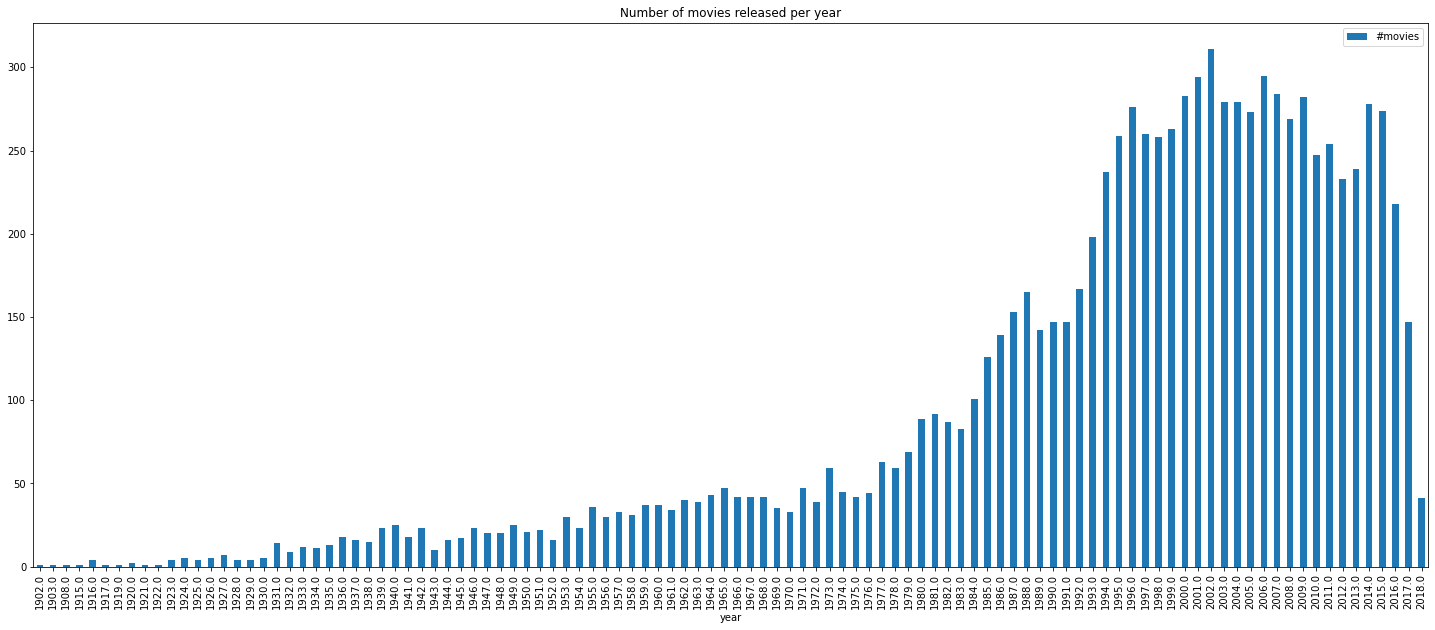

In [103]:
df_temp = df_movie[['release_year', 'movieId']].groupby(['release_year']).count().reset_index().rename(columns={'release_year':'year', 'movieId':'#movies'})
df_temp.plot.bar('year', '#movies', title='Number of movies released per year', figsize=(25, 10));

In [75]:
df_temp = df_rating.merge(df_movie, left_on='movieId', right_on='movieId', how='left')
df_final = df_temp.merge(df_tags, left_on='movieId', right_on='movieId', how='left')
df_final.head()

,userId_x,movieId,rating,timestamp_x,title,genres,release_year,userId_y,tag,timestamp_y
0,1,1,4.0,964982703,To,Adventure|Animation|Children|Comedy|Fantasy,1995.0,336.0,pixar,1.139046e+09
1,1,1,4.0,964982703,To,Adventure|Animation|Children|Comedy|Fantasy,1995.0,474.0,pixar,1.137207e+09
2,1,1,4.0,964982703,To,Adventure|Animation|Children|Comedy|Fantasy,1995.0,567.0,fun,1.525286e+09
3,1,3,4.0,964981247,Grumpier,Comedy|Romance,1995.0,289.0,moldy,1.143425e+09
4,1,3,4.0,964981247,Grumpier,Comedy|Romance,1995.0,289.0,old,1.143425e+09


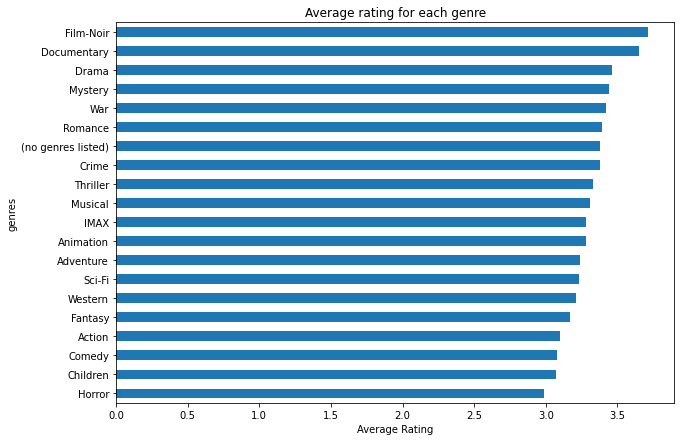

In [115]:
df_temp = pd.DataFrame(columns=['genres', 'avg_rating'])
for genres in genres_unique.genres:
    row = [genres, round(df_final[df_final[genres]==True][['rating']].mean(), 2).to_string()[6:]]
    df_temp.loc[len(df_temp)] = row
df_temp['avg_rating'] = pd.to_numeric(df_temp['avg_rating'])
df_temp = df_temp.sort_values('avg_rating', ascending=True).set_index('genres')
plot_fig = df_temp['avg_rating'].plot(kind='barh', figsize=(10,7))
plot_fig.set_title('Average rating for each genre')
plot_fig.set_xlabel('Average Rating');

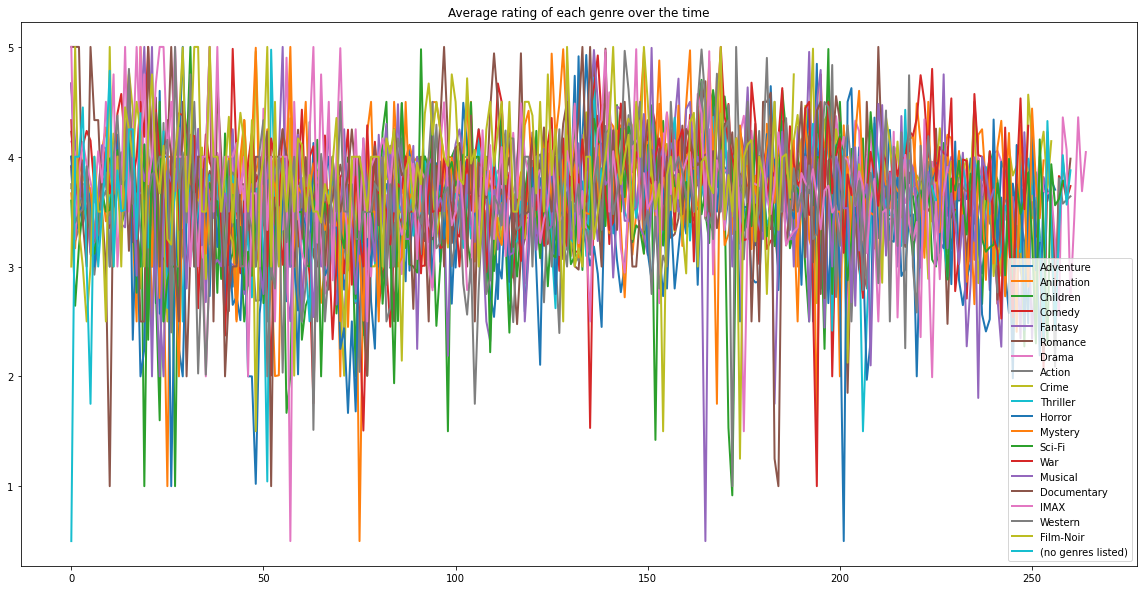

In [120]:
plt.figure(figsize=(20,10)) 
for genres in genres_unique.genres:
    df_temp = df_final[df_final[genres]==True][['year', 'month', 'rating']]
    df_temp = df_temp.groupby(['year', 'month'])['rating'].agg([np.mean]).reset_index()
    plt.plot(df_temp['mean'], linewidth=2.0, label=genres)
plt.title('Average rating of each genre over the time')
plt.legend()
plt.show()

In [19]:
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [20]:
df_links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


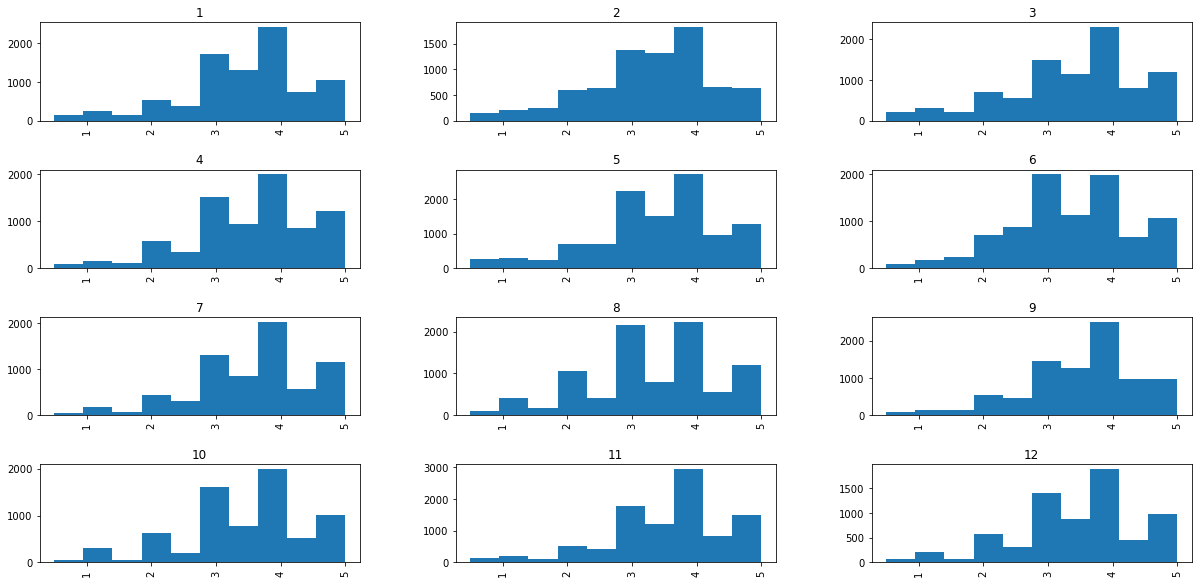

In [41]:
df_rating['rating'].hist(by=df_rating['month'], figsize=(20, 10));

In [45]:
df_rating['userId'].value_counts().nlargest(n=25)

414    2698
599    2478
474    2108
448    1864
274    1346
610    1302
68     1260
380    1218
606    1115
288    1055
249    1046
387    1027
182     977
307     975
603     943
298     939
177     904
318     879
232     862
480     836
608     831
600     763
483     728
590     728
105     722
Name: userId, dtype: int64

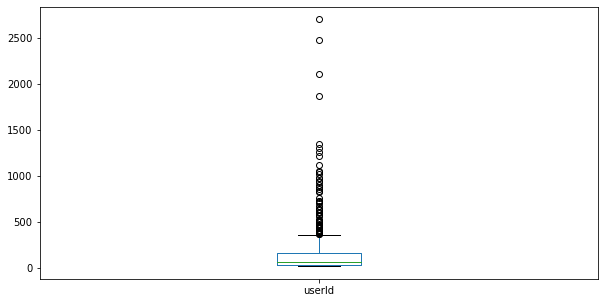

In [47]:
df_rating['userId'].value_counts().plot.box(figsize=(10, 5));

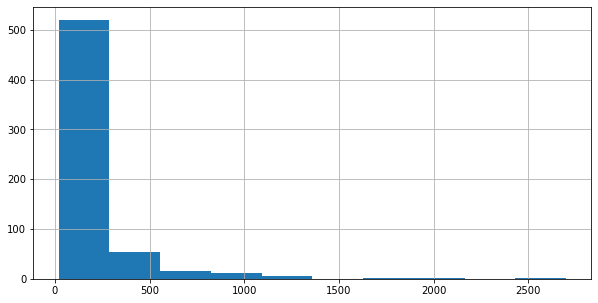

In [48]:
df_rating['userId'].value_counts().hist(figsize=(10, 5));
#From the histogram we can observe the number reviews done by specific number of people

In [52]:
#This tells us users with the most number of ratings
df_rating['movieId'].value_counts().nlargest(n=10)

356     329
318     317
296     307
593     279
2571    278
260     251
480     238
110     237
589     224
527     220
Name: movieId, dtype: int64

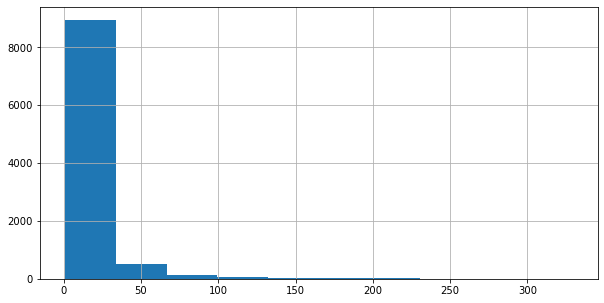

In [54]:
#Movies with the most number of ratingsdf_rating['movieId'].value_counts().hist(figsize=(10, 5));

In [72]:
df_movie.head()

,movieId,title,release_year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,To,NaN,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2,,NaN,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,Grumpier,NaN,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,4,Waiting to,NaN,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
4,5,Father of the Bride,NaN,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [66]:
# Printing unique genres. This is also given in the dataset description file
genres_unique = pd.DataFrame(df_movie.genres.str.split('|').tolist()).stack().unique()
print('Unique genres', genres_unique)
genres_unique = pd.DataFrame(genres_unique, columns=['genres'])

Unique genres ['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'War' 'Musical'
 'Documentary' 'IMAX' 'Western' 'Film-Noir' '(no genres listed)']


In [69]:
df_movie = df_movie.join(df_movie.genres.str.get_dummies().astype(bool))
df_movie.drop('genres', inplace=True, axis=1)

In [70]:
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movieId             9742 non-null   int64  
 1   title               9742 non-null   object 
 2   release_year        0 non-null      float64
 3   (no genres listed)  9742 non-null   bool   
 4   Action              9742 non-null   bool   
 5   Adventure           9742 non-null   bool   
 6   Animation           9742 non-null   bool   
 7   Children            9742 non-null   bool   
 8   Comedy              9742 non-null   bool   
 9   Crime               9742 non-null   bool   
 10  Documentary         9742 non-null   bool   
 11  Drama               9742 non-null   bool   
 12  Fantasy             9742 non-null   bool   
 13  Film-Noir           9742 non-null   bool   
 14  Horror              9742 non-null   bool   
 15  IMAX                9742 non-null   bool   
 16  Musica

In [71]:
df_movie.head()

,movieId,title,release_year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,To,NaN,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2,,NaN,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,Grumpier,NaN,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,4,Waiting to,NaN,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
4,5,Father of the Bride,NaN,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
